In [68]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam as Adam_new
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Flatten, Input
import math
from pickle import dump, load
import os

# Data Perparation

In [2]:
co2_url = 'CO2Data.csv'
co2Data = pd.read_csv(co2_url)

# Read Greenhouse Gases data
gg_url = 'GreenhouseGasses.csv'
ggData = pd.read_csv(gg_url)

# Read Surface Temperature Change data
temp_url = 'TempData.csv'
tempData = pd.read_csv(temp_url)

In [3]:
co2Data = co2Data.fillna(co2Data.mean())
ggData = ggData.fillna(ggData.mean())
tempData = tempData.fillna(tempData.mean())

In [4]:
co2Data.rename(columns={'year': 'Year'}, inplace=True)

# filter dataframes to include data from 1974 to 2021 only
ggData = ggData[(ggData['Year'] >= 1979) & (ggData['Year'] <= 2021)]
tempData = tempData[(tempData['Year'] >= 1979) & (tempData['Year'] <= 2021)]
co2Data = co2Data[(co2Data['Year'] >= 1979) & (co2Data['Year'] <= 2021)]

# merge the dataframes
df = pd.merge(ggData, tempData, on='Year')
df = pd.merge(df, co2Data, on='Year')

In [5]:
# Define a dictionary with old column names as keys and new column names as values
rename_dict = {
    'Year': 'Year',
    'CO2': 'CO2',
    'CH4': 'Methane',
    'N2O': 'Nitrous_Oxide',
    'CFC*': 'CFCs',
    'HCFCs': 'Hydrochlorofluorocarbons',
    'HFCs*': 'Hydrofluorocarbons',
    'Total': 'Total_Greenhouse_Gases_Heat',
    'Total.1': 'Total_Greenhouse_Gases_Concentration',
    '1990 = 1': 'Increase_Since_1990',
    'change **': 'Change_In_Temperature_Since_1967',
    'Value': 'Surface_Temperature',
    'mean': 'CO2_Concentration',
    'unc': 'CO2_Uncertainty'
}

# Rename the columns
df.rename(columns=rename_dict, inplace=True)
df = df.drop(columns=['CO2_Uncertainty'])

# LSTM model

In [6]:
data=df.copy()

In [7]:
target_variables = ['CO2', 'Methane', 'Nitrous_Oxide', 'CFCs',
       'Hydrochlorofluorocarbons', 'Hydrofluorocarbons',
       'Total_Greenhouse_Gases_Heat', 'Total_Greenhouse_Gases_Concentration',
       'Increase_Since_1990', 'Change_In_Temperature_Since_1967', 'Surface_Temperature', 'CO2_Concentration']
train_variables = ['CO2', 'Methane', 'Nitrous_Oxide', 'CFCs',
       'Hydrochlorofluorocarbons', 'Hydrofluorocarbons',
       'Total_Greenhouse_Gases_Heat', 'Total_Greenhouse_Gases_Concentration',
       'Increase_Since_1990', 'Change_In_Temperature_Since_1967', 'Surface_Temperature', 'CO2_Concentration']

variables_to_convert = ["CO2", "Methane", "Nitrous_Oxide", "CFCs", "Hydrochlorofluorocarbons", "Hydrofluorocarbons", "Total_Greenhouse_Gases_Heat"]



In [8]:
def extend_df(df: pd.DataFrame, row: pd.Series):
    new_df = pd.DataFrame([row])
    df = pd.concat([df, new_df], axis=0, ignore_index=True)
    return df

def generate_data(data: pd.DataFrame, scale: int):
    new_data = pd.DataFrame(columns=data.columns)
    new_index = 0
    for ii in range(data.shape[0]-1):
        new_data = extend_df(new_data, data.iloc[ii])
        new_index += 1
        step = (data.iloc[ii + 1] - data.iloc[ii]) / scale
        for scale_indedx in range(1, scale + 1):
            new_data = extend_df(new_data, new_data.iloc[- 1] + step * scale_indedx)
    return new_data
        


In [99]:
data_s3 = generate_data(data, 10)
data = data_s3

In [100]:
# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[target_variables])

In [101]:

# Define the number of time steps (lags) to consider
time_steps = 1

# Prepare the training data
train_data = data_scaled[data['Year'] < 2012]
X_train = []
y_train = []
for i in range(time_steps, len(train_data)):
    X_train.append(data_scaled[i - time_steps:i]) # [:, [0,3]]
    y_train.append(data_scaled[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Prepare the test data
test_data = data_scaled[data['Year'] >= 2012]
X_test = []
y_test = []
for i in range(0, len(test_data)):
    val=i+len(train_data)
    X_test.append(data_scaled[val - time_steps:val]) # [:, [0,3]]
    y_test.append(test_data[i])

X_test = np.array(X_test)
y_test = np.array(y_test)

In [102]:
# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(32, activation='tanh'))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(len(target_variables), activation='linear'))  # Adjust the output dimension based on the number of target variables

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[MeanAbsoluteError()])

# Train the model
history=model_lstm.fit(X_train, y_train, epochs=1000, batch_size=16, verbose=0)

In [94]:
def convert_watt_per_m2_to_joule_per_year(watt_per_m2):
    total_surface_area_earth_m2 = 5.1 * 10**14
    seconds_per_year = 60 * 60 * 24 * 365
    joules_per_year = watt_per_m2 * total_surface_area_earth_m2 * seconds_per_year
    return joules_per_year

In [96]:
def lstm_prediction(input_year, scale = 1):
    prediction_val = []
    if input_year>2021:
        # Prepare the input data
        input_data = data[data['Year'] <= 2021]
        input_data_scaled = scaler.transform(input_data[target_variables])
        # Prepare the input sequence
        input_sequences = []
        for i in range(len(input_data_scaled) - time_steps, len(input_data_scaled)):
            input_sequences.append(input_data_scaled[i - time_steps:i])

        for year in range(2022, input_year + 1):
            for _ in range(scale):
                input_sequences_array = np.array([sequence for sequence in input_sequences if len(sequence) == time_steps])
                input_sequence_reshaped = np.reshape(input_sequences_array, (input_sequences_array.shape[0], input_sequences_array.shape[1], len(target_variables)))

                # Make predictions for the input sequence
                predictions = model_lstm.predict(input_sequence_reshaped[-1].reshape(1, time_steps, len(target_variables)))

                # Inverse transform the predicted values
                prediction = scaler.inverse_transform(predictions)

                # Get the predicted values for the current year
                predicted_values = prediction[0]
                
                # Append the predicted values to the results
                prediction_val.append(predicted_values)
                # for variable, value in zip(target_variables, prediction_val[-1]):
                #   print(f"{variable}: {value}")
                # Update the input sequence for the next iteration
                input_sequences[0][:-1] = input_sequences[0][1:]  # Remove the first value
                input_sequences[0][-1] = np.array(predictions)  # Add predictions at the last index
    else:
        input_data = data[data['Year'] < input_year]
        input_data_scaled = scaler.transform(input_data[target_variables])
        print("h1")
        # Prepare the input sequence
        input_sequence = []
        for i in range(len(input_data_scaled) - time_steps, len(input_data_scaled)):
            input_sequence.append(input_data_scaled[i - time_steps:i])

        input_sequence = np.array(input_sequence)

        # Reshape the input sequence for LSTM (input_shape: [samples, time_steps, features])
        input_sequence = np.reshape(input_sequence, (input_sequence.shape[0], input_sequence.shape[1], len(target_variables)))

        # Make predictions for the input sequence
        predictions = model_lstm.predict(input_sequence)

        # Inverse transform the predicted values
        prediction_val = scaler.inverse_transform(predictions)

        # Get the predicted values for the year 2022
        predicted_values = prediction_val[-1]
        # Get the predicted values for the year 2022
        predicted_values = prediction_val[-1]
    # predicted_values = [convert_watt_per_m2_to_joule_per_year(val) for val in prediction_val[-1]]
    return predicted_values

# Regression model

In [41]:
class LSRM:
    def __init__(self, coeff: np.ndarray, degree: int = 3):
        self.coeff = coeff
        self.degree = degree

    def convert_watt_per_m2_to_joule_per_year(self, watt_per_m2):
        # Constants
        total_surface_area_earth_m2 = 5.1 * 10**14  # Total surface area of the Earth in m²
        seconds_per_year = 60 * 60 * 24 * 365  # Number of seconds in a year
        # Conversion
        joules_per_year = watt_per_m2 * total_surface_area_earth_m2 * seconds_per_year
        return joules_per_year

    def predict(self, year: int):
        all_predictions = []
        for c in range(12):
            prediction = 0
            coeff = self.coeff[c]
            for index2 in range(self.degree+1):
                prediction+=coeff[len(coeff)-index2-1]*float(year)**index2
                # converted_prediction = self.convert_watt_per_m2_to_joule_per_year(prediction)
            all_predictions.append(prediction)
        return all_predictions

In [42]:
def create_lsrm(coeff: np.ndarray):
    return LSRM(coeff)

In [43]:
loaded_coefficients = load(open('coefficients.pkl', 'rb'))
model_lsrm = create_lsrm(loaded_coefficients)

# Test Models

In [104]:
start_year = 2010
end_year = 2051
lsrm_predictions = []
lstm_predictions = []
for year in range(start_year, end_year):
    lsrm_predictions.append(model_lsrm.predict(year))
    lstm_predictions.append(lstm_prediction(year, 10))
df_lsrm = pd.DataFrame(lsrm_predictions, columns=target_variables)
df_lstm = pd.DataFrame(lstm_predictions, columns=target_variables)

df_lsrm[variables_to_convert] = df_lsrm[variables_to_convert].applymap(convert_watt_per_m2_to_joule_per_year)
df_lstm[variables_to_convert] = df_lstm[variables_to_convert].applymap(convert_watt_per_m2_to_joule_per_year)

h1
1/1 [==============================] - 0s 14ms/step
h1
1/1 [==============================] - 0s 11ms/step
h1
1/1 [==============================] - 0s 12ms/step
h1
1/1 [==============================] - 0s 11ms/step
h1
1/1 [==============================] - 0s 11ms/step
h1
1/1 [==============================] - 0s 12ms/step
h1
1/1 [==============================] - 0s 11ms/step
h1
1/1 [==============================] - 0s 11ms/step
h1
1/1 [==============================] - 0s 11ms/step
h1
1/1 [==============================] - 0s 12ms/step
h1
1/1 [==============================] - 0s 12ms/step
h1
1/1 [==============================] - 0s 11ms/step


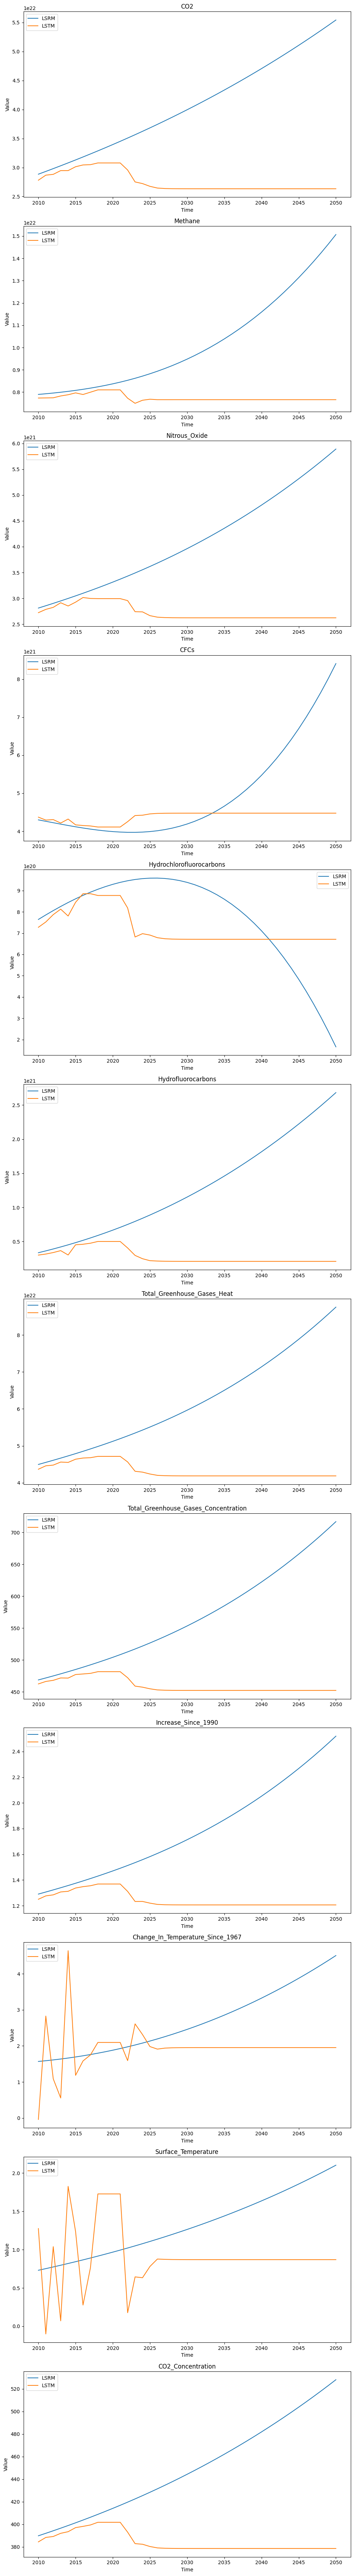

In [105]:
# Plot actual vs predicted for each target variable
fig, axes = plt.subplots(len(target_variables), 1, figsize=(10, 6 * len(target_variables)))
years = [year for year in range(start_year, end_year)]
for i, target_variable in enumerate(target_variables):
    # axes[i].plot(years, data[target_variable], label='Actual')
    axes[i].plot(years, df_lsrm[target_variable], label='LSRM')
    axes[i].plot(years, df_lstm[target_variable], label='LSTM')
    axes[i].set_title(target_variable)
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')
    axes[i].legend()

plt.tight_layout()
plt.show()